In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from pandas.api.types import CategoricalDtype
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPClassifier 
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,RobustScaler
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier,VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [3]:
train=pd.read_csv('C://Users/itzha/Downloads/New folder/train.csv')
test=pd.read_csv('C://Users/itzha/Downloads/New folder/test.csv')

In [4]:
train.shape

(800, 22)

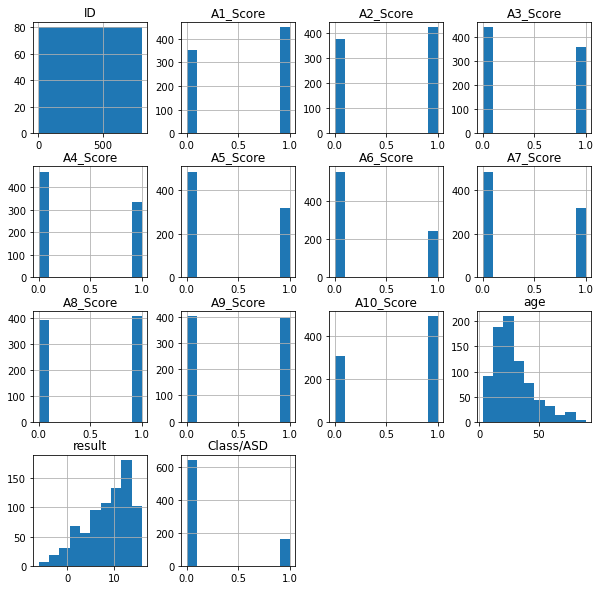

In [5]:
train.hist(figsize=(10,10))
plt.show()

In [6]:
test.shape

(200, 21)

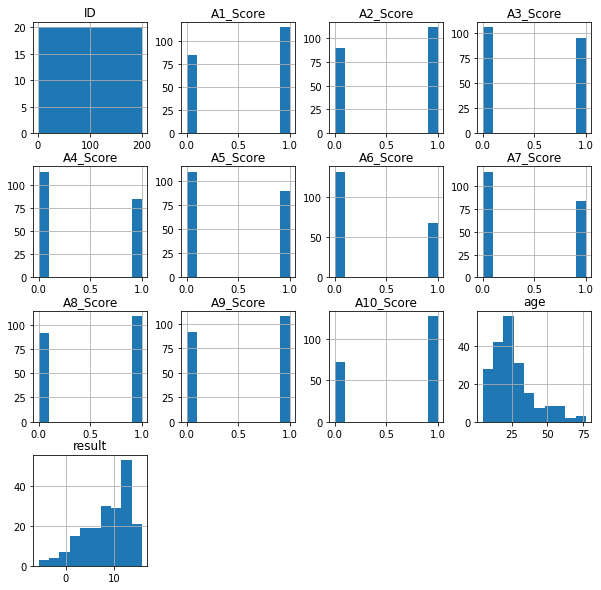

In [7]:
test.hist(figsize=(10,10))
plt.show()

<AxesSubplot:>

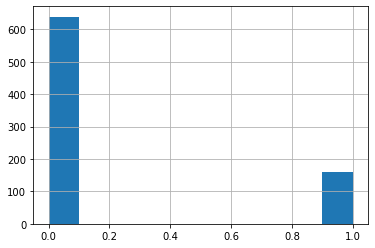

In [8]:
#Data is heavily imbalanced, so we'll need oversampling
train['Class/ASD'].hist()

In [9]:
#no nulls in the training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [10]:
#no nulls in the training set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               200 non-null    int64  
 1   A1_Score         200 non-null    int64  
 2   A2_Score         200 non-null    int64  
 3   A3_Score         200 non-null    int64  
 4   A4_Score         200 non-null    int64  
 5   A5_Score         200 non-null    int64  
 6   A6_Score         200 non-null    int64  
 7   A7_Score         200 non-null    int64  
 8   A8_Score         200 non-null    int64  
 9   A9_Score         200 non-null    int64  
 10  A10_Score        200 non-null    int64  
 11  age              200 non-null    float64
 12  gender           200 non-null    object 
 13  ethnicity        200 non-null    object 
 14  jaundice         200 non-null    object 
 15  austim           200 non-null    object 
 16  contry_of_res    200 non-null    object 
 17  used_app_before 

<AxesSubplot:xlabel='A6_Score', ylabel='count'>

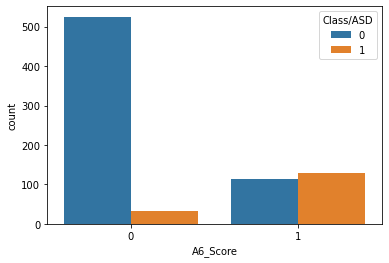

In [11]:
#just for demonstration, in the plot there is a significant difference between the ratio of the classes
#when we change the A6-score, which suggests a strong relation between this feature and the target
sns.countplot(train.A6_Score,data=train,hue=train['Class/ASD'])

In [12]:
train_set=train.copy()
test_set=test.copy()

#age_desc doesn't change and ID is irrelevant
train_set.drop(['age_desc','ID'],axis=1,inplace=True)

test_set.drop(['age_desc','ID'],axis=1,inplace=True)

In [13]:
#Dropping useless features using chi 2

train_set.drop(['gender','used_app_before'],axis=1,inplace=True)
test_set.drop(['gender','used_app_before'],axis=1,inplace=True)

In [14]:
#separating the target column from the rest of the data
y=train_set.pop('Class/ASD')

In [15]:
#to group ages in 4, as a part of encoding
def age_grouper(df):
    for row in range(df.shape[0]):
        if df.age.iloc[row]<=14: df.age.iloc[row]=1
        if 14<df.age.iloc[row]<=24: df.age.iloc[row]=2
        if 24<df.age.iloc[row]<=64: df.age.iloc[row]=3
        if 64<df.age.iloc[row]: df.age.iloc[row]=4

In [16]:
np.random.seed(1) #I'm using this because there's some
#randomness in how the selectors work, without this, in each run we get different results
kf = StratifiedKFold(n_splits=2, random_state=None,shuffle=False) #for cross validation/ random_state
# is None because shuffle is False
score=[]

for train_index, val_index in kf.split(train_set,y):
    
    #indices for train and validation sets
    X_train, X_val =train_set.iloc[train_index,:], train_set.iloc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]
    
    #******************************* CLEANING ***********************************

    #for train set
    X_train.ethnicity=X_train.ethnicity.str.replace('others','Others',regex=False)
    X_train.ethnicity=X_train.ethnicity.str.replace('?','Others',regex=False)
    X_train.relation=X_train.relation.str.replace('?','Others',regex=False)
    X_train.relation=X_train.relation.str.replace('Health care professional','Others',regex=False)
      
    
    #for validation set:
    X_val.ethnicity=X_val.ethnicity.str.replace('others','Others',regex=False)
    X_val.ethnicity=X_val.ethnicity.str.replace('?','Others',regex=False)
    X_val.relation=X_val.relation.str.replace('?','Others',regex=False)
    X_val.relation=X_val.relation.str.replace('Health care professional','Others',regex=False)

  
    #***************************************ENCODING****************************************** 
    
    #FOR ENCODING USE THE TRAINING VALUES, DO NOT CALCULATE THEM AGAIN FOR THE TEST SET!
    
    le=LabelEncoder()
    for col in ['jaundice','austim']:
        
        #for the training set:
        X_train[col]=le.fit_transform(X_train[col])
        
        #for the validation set:
        X_val[col]=le.transform(X_val[col])
         
  #*********************Encoding Relation Column***************************
    
    #create an encoding map, using the training set, then implementing it on val and test sets
    rel=X_train.relation.value_counts()
    rel=dict(zip(rel.index,range(len(rel))))
    
    #for the training set:
    X_train.relation=X_train.relation.map(rel)
    
    #for the validation set: if there's a category not present in the map, we'll assign sth. to it
    X_val.relation=X_val.relation.map(rel)
    X_val.relation[X_val.relation.isna()]=len(rel)
    
    
    
    #*********************Encoding Ethnicity Column***************************
    
    #create an encoding map, using the training set, then implementing it on val and test sets
    eth=X_train.ethnicity.value_counts()
    eth=dict(zip(eth.index,range(len(eth))))
    
    #for the training set:
    X_train.ethnicity=X_train.ethnicity.map(eth)
     #for the validation set: if there's a category not present in the map, we'll assign sth. to it
    X_val.ethnicity=X_val.ethnicity.map(eth)
    X_val.ethnicity[X_val.ethnicity.isna()]=len(eth)
    
    
    #*****************************Encoding Country Of Res******************************
    
    #create an encoding map, using the training set, then implementing it on val and test sets
    cont=X_train.contry_of_res.value_counts()
    cont=dict(zip(cont.index,range(len(cont))))
    
    #for the training set:
    X_train.contry_of_res=X_train.contry_of_res.map(cont)
    
    #for the validation set: if there's a category not present in the map, we'll assign sth. to it
    X_val.contry_of_res=X_val.contry_of_res.map(cont)
    X_val.contry_of_res[X_val.contry_of_res.isna()]=len(cont)

    #***************************Age Grouping***********************************
    
#     age_grouper(X_train)
#     age_grouper(X_val)

                #*******************************Standardization*************************
    ss=StandardScaler()
    rs=RobustScaler()
    X_train[['result','age']]=rs.fit_transform(X_train[['result','age']])
    X_val[['result','age']]=rs.transform(X_val[['result','age']])

In [17]:
model_list = ['KNearestNeighbours', 'DecisionTree', 'LGBM','XGBRF','CatBoostClassifier','RandomForest','Logistic Regression', 'SVC' ]

In [18]:
# K Neighbors Classifier

kn_clf = KNeighborsClassifier(n_neighbors=6)
kn_clf.fit(X_train,y_train)
y_pred=pd.DataFrame(kn_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644])

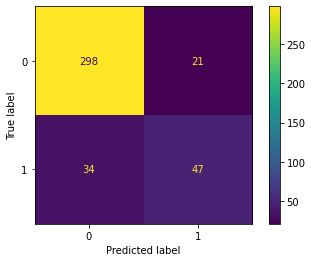

In [19]:
cm = confusion_matrix(y_val, kn_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();


In [20]:
#DecissionTree
dt_clf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0, criterion='entropy')
dt_clf.fit(X_train, y_train)
y_pred=pd.DataFrame(dt_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541])

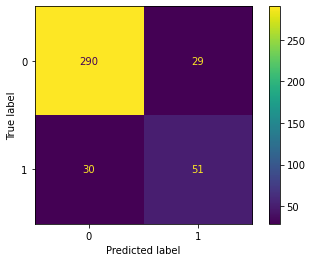

In [21]:
cm = confusion_matrix(y_val, dt_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [22]:
#  lightgbm 
import lightgbm
lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
lgb_clf.fit(X_train, y_train)
y_pred=pd.DataFrame(lgb_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  ])

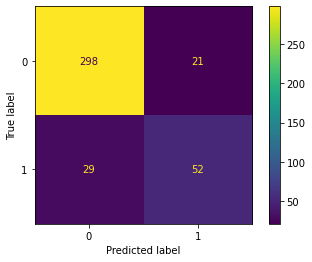

In [23]:
cm = confusion_matrix(y_val, lgb_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [24]:
# xgbrf classifier
import xgboost
xgb_clf = xgboost.XGBRFClassifier(max_depth=4, random_state=1)
xgb_clf.fit(X_train, y_train)
y_pred=pd.DataFrame(xgb_clf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

[21:34:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.88091644, 0.78857541, 0.923391  , 0.92371996])

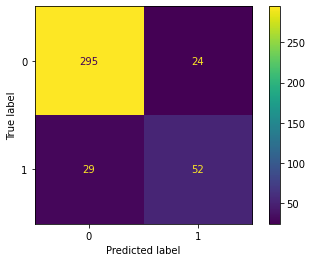

In [25]:
cm = confusion_matrix(y_val, xgb_clf.predict(X_val))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

In [26]:
#cathboost
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(iterations=100,depth=10,random_state=42,auto_class_weights='Balanced')
cat_model.fit(X_train,y_train,plot=False,verbose=0)
y_pred=pd.DataFrame(cat_model.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

array([0.88091644, 0.78857541, 0.923391  , 0.92371996, 0.92542281])

In [31]:
# RF
clf_rf = RandomForestClassifier()      
clf_rf.fit(X_train,y_train)
y_pred=pd.DataFrame(clf_rf.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
np.array(score)


array([0.88091644, 0.78857541, 0.923391  , 0.92371996, 0.92542281,
       0.92513255, 0.92184295, 0.92149464, 0.92482294])

In [ ]:
# logistic regression

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred=pd.DataFrame(log_reg.predict_proba(X_val))[1].values
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

In [ ]:
# svc

clf = SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
score.append(roc_auc_score(y_val,y_pred))
    
np.array(score)

In [ ]:
len(score)
len(model_list)

In [ ]:
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=score, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()